/Users/I766282/PyCharmMiscProject/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


--- 1. Loading and Cleaning Data ---
Data loaded. Valid records: 4549

--- 2. Market Trend Analysis (Buy vs. Wait) ---
Trend Slope: $16103.75 per month
Market Direction: RISING
STRATEGIC RECOMMENDATION: BUY NOW


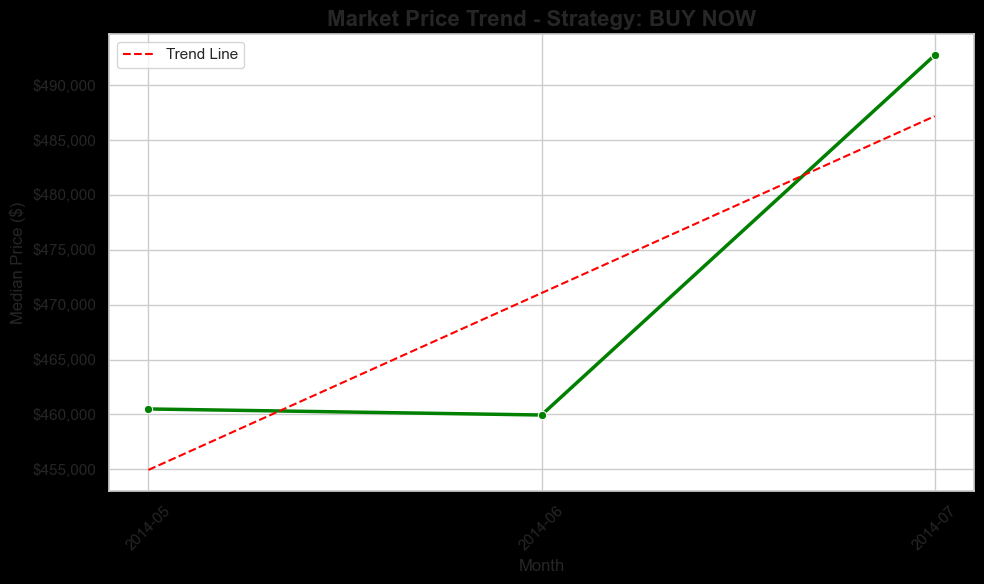


--- 3. Generating Business Graphics ---


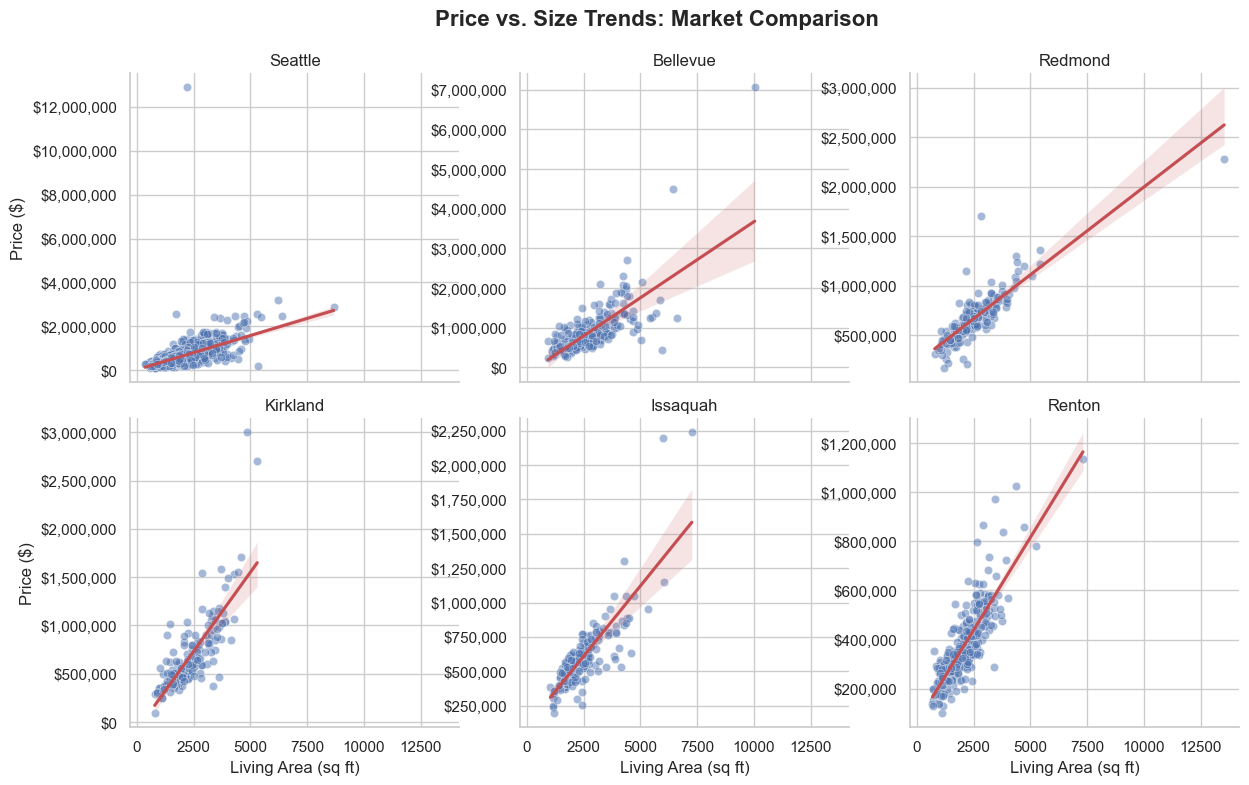

/var/folders/16/__2mqr3j1gsd1bbrntqp_qv00000gn/T/ipykernel_58192/1835660234.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_avg.index, y=city_avg.values, palette="viridis")


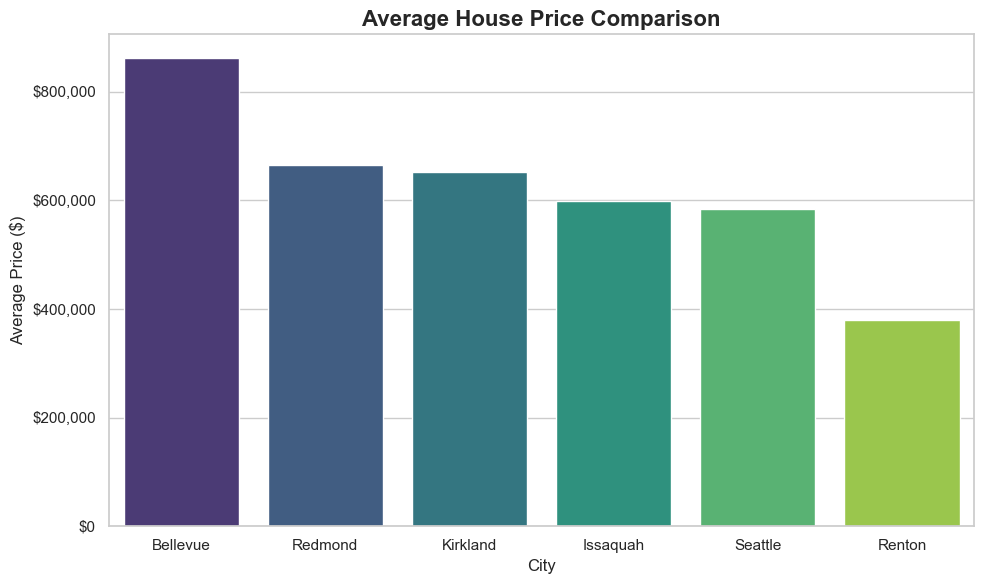


--- 4. Finding & Geocoding Recommendations (This takes ~30s) ---


Geocoding: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


SUCCESS! Found 7 perfect matches near Tech Hubs.
Map saved to 'final_tech_hub_map.html'. Open it in your browser to view.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from tqdm import tqdm



print("--- 1. Loading and Cleaning Data ---")
file_path = 'KC_housing_data (1).csv'
df = pd.read_csv(file_path)


df['date'] = pd.to_datetime(df['date'])


df_clean = df[(df['price'] > 0) & (df['bedrooms'] > 0)].copy()

print(f"Data loaded. Valid records: {len(df_clean)}")




print("\n--- 2. Market Trend Analysis (Buy vs. Wait) ---")


df_clean['year_month'] = df_clean['date'].dt.to_period('M')
monthly_prices = df_clean.groupby('year_month')['price'].median().reset_index()
monthly_prices['year_month_str'] = monthly_prices['year_month'].astype(str)


x = np.arange(len(monthly_prices))
y = monthly_prices['price'].values
slope, intercept = np.polyfit(x, y, 1)


trend_desc = "RISING" if slope > 0 else "FALLING"
recommendation = "BUY NOW" if slope > 0 else "WAIT"

print(f"Trend Slope: ${slope:.2f} per month")
print(f"Market Direction: {trend_desc}")
print(f"STRATEGIC RECOMMENDATION: {recommendation}")

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(x='year_month_str', y='price', data=monthly_prices, marker='o', color='green', linewidth=2.5)
plt.plot(monthly_prices['year_month_str'], slope * x + intercept, color='red', linestyle='--', label='Trend Line')

plt.title(f'Market Price Trend - Strategy: {recommendation}', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Median Price ($)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.legend()
plt.tight_layout()
plt.show()




print("\n--- 3. Generating Business Graphics ---")

# Focus on Top 6 Cities for context
top_cities_list = df_clean['city'].value_counts().head(6).index
df_cities = df_clean[df_clean['city'].isin(top_cities_list)].copy()


g = sns.FacetGrid(df_cities, col="city", col_wrap=3, height=4, sharey=False)
g.map(sns.scatterplot, "sqft_living", "price", alpha=0.5, color="#4c72b0")
g.map(sns.regplot, "sqft_living", "price", scatter=False, color="#c44e52")
g.set_axis_labels("Living Area (sq ft)", "Price ($)")
g.set_titles(col_template="{col_name}")
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Price vs. Size Trends: Market Comparison', fontsize=16, fontweight='bold')
plt.show()


plt.figure(figsize=(10, 6))
city_avg = df_cities.groupby('city')['price'].mean().sort_values(ascending=False)
sns.barplot(x=city_avg.index, y=city_avg.values, palette="viridis")
plt.title('Average House Price Comparison', fontsize=16, fontweight='bold')
plt.xlabel('City')
plt.ylabel('Average Price ($)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
plt.tight_layout()
plt.show()




print("\n--- 4. Finding & Geocoding Recommendations (This takes ~30s) ---")


TECH_HUBS = {
    "Amazon HQ (Seattle)": (47.6159, -122.3399),
    "Microsoft HQ (Redmond)": (47.6423, -122.1369),
    "Google (Kirkland)": (47.6698, -122.1963),
    "Meta (Bellevue)": (47.6101, -122.2015)
}

# Filter Criteria:
# 1. Tech Cities: Seattle, Bellevue, Redmond, Kirkland
# 2. Modern: Built >= 2010
# 3. Urban/Condo: Lot Size < 2500 sqft
tech_cities = ['Seattle', 'Bellevue', 'Redmond', 'Kirkland']
urban_tech_df = df_clean[
    (df_clean['city'].isin(tech_cities)) &
    (df_clean['yr_built'] >= 2010) &
    (df_clean['sqft_lot'] < 2500)
].copy()


candidates = urban_tech_df.sort_values(by='price').head(20).copy()
candidates['full_address'] = candidates['street'] + ", " + candidates['city'] + ", " + candidates['statezip'] + ", " + candidates['country']


locator = Nominatim(user_agent="final_tech_map_v1")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.1)


locations = []
for address in tqdm(candidates['full_address'], desc="Geocoding"):
    try:
        loc = geocode(address)
        if loc:
            locations.append((loc.latitude, loc.longitude))
        else:
            locations.append((None, None))
    except:
        locations.append((None, None))

candidates['lat'] = [x[0] for x in locations]
candidates['lon'] = [x[1] for x in locations]
candidates = candidates.dropna(subset=['lat', 'lon'])


def get_closest_hub(row):
    house_loc = (row['lat'], row['lon'])
    min_dist = float('inf')
    closest_name = None

    for hub_name, hub_loc in TECH_HUBS.items():
        dist = geodesic(house_loc, hub_loc).miles
        if dist < min_dist:
            min_dist = dist
            closest_name = hub_name
    return pd.Series([closest_name, min_dist])

candidates[['closest_hub', 'dist_to_hub']] = candidates.apply(get_closest_hub, axis=1)


final_recommendations = candidates[candidates['dist_to_hub'] < 5].head(7)

print(f"\nSUCCESS! Found {len(final_recommendations)} perfect matches near Tech Hubs.")




if not final_recommendations.empty:

    start_coords = [final_recommendations['lat'].iloc[0], final_recommendations['lon'].iloc[0]]
    tech_map = folium.Map(location=start_coords, zoom_start=11, tiles='CartoDB positron')

    for name, coords in TECH_HUBS.items():
        folium.Marker(
            location=coords,
            popup=f"<b>{name}</b>",
            icon=folium.Icon(color='orange', icon='laptop', prefix='fa')
        ).add_to(tech_map)


    for i, row in final_recommendations.iterrows():
        popup_html = f"""
        <div style="font-family: sans-serif; width: 220px;">
            <b>[RECOMMENDED]</b><br>
            <b>Price:</b> ${int(row['price']):,}<br>
            <b>Built:</b> {row['yr_built']}<br>
            <b>Size:</b> {row['sqft_living']} sqft<br>
            <hr style="margin: 5px 0;">
            <b>Closest Hub:</b><br>
            {row['closest_hub']}<br>
            (Distance: {row['dist_to_hub']:.1f} miles)
        </div>
        """

        folium.Marker(
            location=[row['lat'], row['lon']],
            popup=folium.Popup(popup_html, max_width=250),
            icon=folium.Icon(color='purple', icon='home', prefix='fa')
        ).add_to(tech_map)


    output_file = 'final_tech_hub_map.html'
    tech_map.save(output_file)
    print(f"Map saved to '{output_file}'. Open it in your browser to view.")

    try:
        from IPython.display import display
        display(tech_map)
    except:
        pass
else:
    print("No houses found matching criteria.")